<img src="./img/HWNI_logo.svg"/>

# Lab - One-Way ANOVA

In [1]:
# makes our plots show up inside Jupyter
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

import util.utils as utils
import util.shared as shared

import warnings
warnings.simplefilter("ignore")

shared.format_plots()
shared.format_dataframes()

## About the Dataset

For this week's lab, we'll be using some EEG data graciously provided by the [Voytek lab](http://voyteklab.com/about-us/) of UCSD. Participants of varying ages were asked to perform a working memory task with varying levels of difficulty. The raw EEG signal has been summarized into the following two measures:

* [Contralateral Delay Activity](https://www.ncbi.nlm.nih.gov/pubmed/26802451), or CDA, is used to measure the engagement of visual working memory.

* [Frontal Midline Theta](https://www.ncbi.nlm.nih.gov/pubmed/9895201) oscillation amplitude has been correlated with sustained, internally-directed cognitive activity.

The performance of the subjects has also been summarized using the measure
[d'](https://en.wikipedia.org/wiki/Sensitivity_index) (pronounced "d-prime"), also known as the *sensitivity index*. D' is a measure of the subject's performance in  a task. It's based on comparing the true positive rate and false positive rate.

## Loading the Data

First, we load the data and take a look at a sample.

In [2]:
df = pd.read_csv('./data/voytek_working_memory_aging_split.csv',index_col=None)

df.sample(5)

,idx,id,age_split,group,age,difficulty,d,cda,fmt
44,20,21,3,2,55,2,4.25,1.73,-0.34
16,16,17,3,2,57,1,4.70,1.03,0.06
57,9,10,1,1,21,3,4.65,1.84,1.57
32,8,9,1,1,19,2,3.52,3.26,1.03
60,12,13,4,2,61,3,2.29,0.55,0.42


For the purposes of this lab, we're interested only in how task difficulty affects our three measures. We're uninterested in the subject's metadata -- `age_split`, `group`, `age`, and `idx`. Let's begin by dropping those columns from our dataframe using the DataFrame method `drop`.

In [3]:
data = df.drop(['age_split','group','age','idx'], axis=1)
data[data.id == 1]

,id,difficulty,d,cda,fmt
0,1,1,4.86,1.00,0.80
24,1,2,4.89,2.04,0.49
48,1,3,4.55,1.81,0.29


It's good practice to keep an original copy of your dataframe around (here, named `df`) so you can undo irreversible changes, like dropping columns.

If we're interested in looking at subject-by-subject information, we're not quite done with formatting our data. For subject-level analysis, our data is not yet tidy, since a single subject's observations are scattered over multiple rows. Use the `pivot` method to tidy our data. Hint: we want to get our row `index`es from the subject's `id` and to make new `columns` for our measures using the level of `difficulty`. Look back at the last lab (Lab B) for an example of using `pivot`.

In [4]:
pivot_data = data.pivot(index='id', columns='difficulty')

In [5]:
pivot_data.sample(5)

d               cda               fmt            
difficulty     1     2     3     1     2     3     1     2     3
id                                                              
1           4.86  4.89  4.55  1.00  2.04  1.81  0.80  0.49  0.29
3           4.71  4.29  2.92  0.84  1.36  1.18  0.31  0.22 -0.07
6           3.82  4.18  2.97  0.84  2.12  3.00 -1.12 -0.35 -0.03
9           4.02  3.52  3.26  2.19  3.26  3.12  1.00  1.03  0.66
15          4.86  4.46  4.05  1.36  1.17  1.02  0.23  0.26  0.62

It now takes two pieces of information to pick out a particular column: the measure we're interested in (one of `d`, `cda`, or `fmt`) and the `difficulty` level: `1`, `2`, or `3`. These need to be provided in order.

In [6]:
measure = 'cda'
difficulty = 2

pivot_data[measure, difficulty].head()

id
1    2.04
2    0.73
3    1.36
4    1.79
5    0.75
Name: (cda, 2), dtype: float64

If we instead only index into the first level, we get a single-level dataframe back:

In [7]:
pivot_data[measure].head()

difficulty,1,2,3
id,,,
1,1.00,2.04,1.81
2,0.70,0.73,0.80
3,0.84,1.36,1.18
4,1.59,1.79,2.25
5,1.59,0.75,0.98


## Visualizing the Data

Below, we'll be running ANOVA using difficulty as an independent factor and the three measures as dependent factors. Choose a visualization or collection of visualizations that you think would be appropriate for this purpose and plot the data below. Be ready to explain your choice in class.

You can use either the `pivot`ed data frame or the un`pivot`ed data frame.

Hint: the easiest way to apply most of our visualizations to this dataset is to write a loop that runs over our measures and produces a separate plot for each one.

Template:
```python
for measure in ["cda","fmt","d"]:
    plt.figure()
    data = pivot_data[measure]
    sns.?
    ...
    plt.title(measure+" versus difficulty")
```

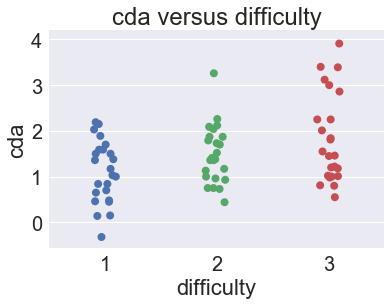

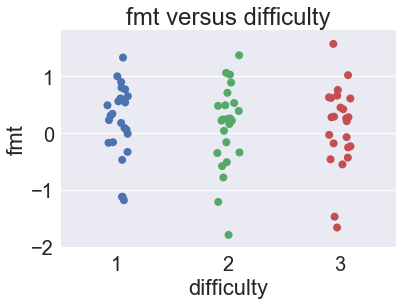

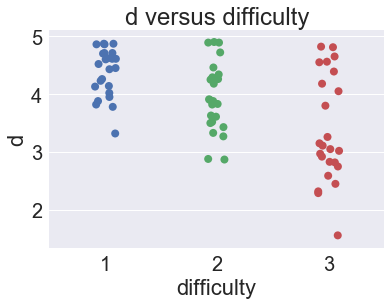

In [8]:
# answer

for measure in ["cda","fmt","d"]:
    plt.figure()
    sns.stripplot(data=pivot_data[measure],s=8,jitter=True);
    plt.ylabel(measure)
    plt.title(measure+" versus difficulty")

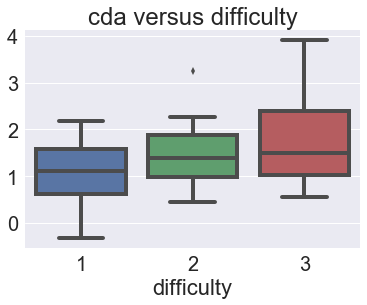

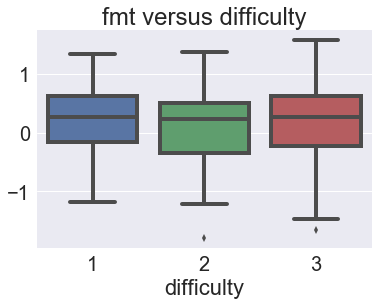

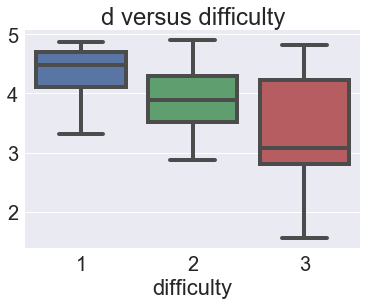

In [9]:
for measure in ["cda","fmt","d"]:
    plt.figure()
    sns.boxplot(data=pivot_data[measure],
                    linewidth=4);
    plt.title(measure+" versus difficulty")

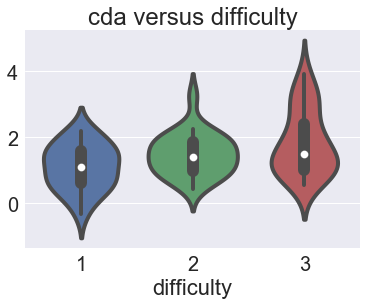

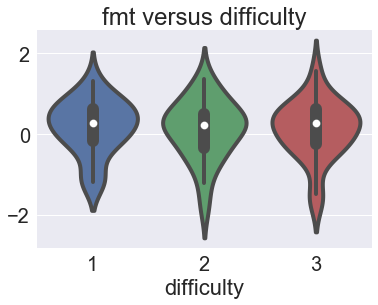

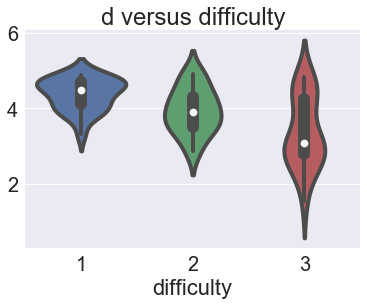

In [10]:
# answer

for measure in ["cda","fmt","d"]:
    plt.figure()
    sns.violinplot(data=pivot_data[measure],
                    linewidth=4);
    plt.title(measure+" versus difficulty")

Recall the assumptions behind ANOVA.

#### Q1 Based off of your visualization, do you think any of the assumptions of ANOVA are being violated for the case of fmt? What about d'?

<font color='#1874CD'> ** For `fmt`, all looks well. The within-variance seems to be quite different in the case of `d'`, and there's a hint of bimodality in the higher-difficulty condition.**

## Built-In Tools for ANOVA

### Using `scipy`

First, we'll use the built-in `scipy.stats` function `f_oneway` to perform One-Way ANOVA.

In [11]:
scipy.stats.f_oneway?

Try to organize the code you write in the cell below so that you minimize the amount you repeat yourself.

In [12]:
# answer
def run_ANOVA(data, measure):
    return scipy.stats.f_oneway(*[pivot_data[measure, key] 
                       for key in pivot_data[measure].columns])

# * here is called "splat" or "unpack" and it takes a list (or something like a list)
# and turns it, in order, into the arguments of a function.
# checkout https://codeyarns.com/2012/04/26/unpack-operator-in-python/ for more

In [13]:
# answer
# one way to do it

print("="*13)
for measure in ["cda","d","fmt"]:
    print("ANOVA for "+ measure)
    print(run_ANOVA(pivot_data, measure))
    print("="*13)

ANOVA for cda
F_onewayResult(statistic=5.360615782548718, pvalue=0.006854734794988666)
ANOVA for d
F_onewayResult(statistic=13.162307279101022, pvalue=1.4378683792723512e-05)
ANOVA for fmt
F_onewayResult(statistic=0.07347259463334953, pvalue=0.9292342023055878)


In [14]:
# answer
# another fine alternative

measure = "cda"

scipy.stats.f_oneway(*[pivot_data[measure,key] 
                       for key in pivot_data[measure].columns])

F_onewayResult(statistic=5.360615782548718, pvalue=0.006854734794988666)

#### Follow-Up $t$-Tests

Select a measure with a significant ANOVA result and take a look at the data as you plotted it above.

It's often tempting to conclude on the basis of the ANOVA result
that any pattern we see or don't see in the data must be "real",
i.e. reflect a statistically significant result.

For example, on the measure `cda`,
we might be tempted to conclude that difficulty levels 2 and 3
are significantly different from difficulty level 1.

But a significant ANOVA result does not make a statement about
which levels of the factor are different from each other;
instead, it only says that the levels are somehow different.

To determine where the effect is coming from,
we need to perform follow-up $t$-tests
where we compare the means of two factor levels directly.
These tests will help us determine which inter-group differences are statistically significant.

In the cell below,
use `scipy.stats.ttest_ind`
(which we learned about in the two-sample testing lab)
to perform follow-up $t$-tests comparing
the contralateral delay activity, `cda`,
across difficulty levels -- 1 vs 2, 2 vs 3, and 1 vs 3.

In [15]:
# answer
difficulty_levels = [2, 3]

scipy.stats.ttest_ind(*[pivot_data[measure][difficulty_level]
                       for difficulty_level in difficulty_levels])

Ttest_indResult(statistic=-1.4882486738182978, pvalue=0.14350924560594913)

#### Q2 What are your results? Are they different from what you expected?

<font color='#1874CD'> **I found a statistically significant difference at $p < .05 $ only between difficulty levels 1 and 3. This is somewhat surprising, since it would appear, just from the graph, that levels 1 and 2 are also significantly different. **

You may be wondering what the point of the initial ANOVA was,
given that we needed to run additional statistical testing in order to determine our results.
Why not just go straight to the $t$-tests?

As mentioned in the tutorial for this section,
ANOVA first tests the null hypothesis that
all of the groups means are the same as the grand mean.
If we reject this null hypothesis only if $p < \alpha$,
then we know that the familywise error rate
for our follow-up $t$-tests can't be greater than $\alpha$,
since, if the null hypothesis is true,
we only perform them with probability $\alpha$.

Put less technically,
the initial ANOVA provides "cover" for our follow-up $t$-tests,
eliminating our multiple comparisons problem
by controlling the familywise error rate for the combined statistical test "ANOVA plus $t$-tests".

### Using `statsmodels`

In [16]:
import statsmodels.api as sm

[`statsmodels`](http://www.statsmodels.org/stable/index.html)
is a Python package that implements
a number of popular features from the statistical computing language
[R](https://www.r-project.org/about.html).

Before we dive into how to use statsmodels,
we need to note that there are two equivalent ways of viewing the ANOVA.
In one view,
the ANOVA is a statistical test related to the $t$-test
but for more complicated experiments.
In the other view,
the ANOVA is a test of how well the data is explained
by the implicit linear model.
We have focused on the former view of ANOVA.

While there are interfaces for running ANOVA in R
that use the framework we've focused on,
there are not any stable,
mature packages for Python that implement
ANOVA in this way.

Instead,
these packages,
including statsmodels,
implement ANOVA as a two step process:

1. Fit the implicit linear model
1. Test the goodness-of-fit of that model.

Models are described,
as they are in R packages that use the same framework,
using *formula strings*.
These are short strings that specify
which columns of a dataframe are observations
and which columns are factors.

The formula functionality
of statsmodels
is complex enough that it
is imported separately
from the rest of statsmodels,
just like `scipy.stats`
is a separate import from `scipy`.

In [17]:
import statsmodels.formula.api as smf

For a One-Way ANOVA,
the formula string is simple:

`'observation ~ factor'`

with one extra complication.
These formulas can describe models with mixtures of
categorical variables,
like our `difficulty` variable,
and numerical variables,
like our `age` variable.
If a categorical variable is coded as a number,
like our `difficulty` variable,
then we have to tell statsmodels
that the numbers in that variable should be treated as
category labels.
We do this by putting the variable's name inside a
`C()`,
like so:

`'observation ~ C(categorical_factor)'`

The statsmodels approach may seem like a lot of extra work,
especially compared to the scipy option.
However, this extra complexity is what
allows statsmodels to represent very complicated ANOVAs.

The cell below runs a One-Way ANOVA for the `cda` measure.
Compare the results to the output of `f_oneway` for this measure,
then change the formula to get the results for each of the other two measures.

In [18]:
formula = 'cda ~ C(difficulty)'

ols_lm = smf.ols(formula, data=data)

fit = ols_lm.fit()

table = sm.stats.anova_lm(fit, typ=2)

table

,sum_sq,df,F,PR(>F)
C(difficulty),6.456736,2.0,5.360616,0.006855
Residual,41.554442,69.0,NaN,NaN


Many folks find it easier to work with ANOVAs
in the formulation we used previously,
ANOVA as a hypothesis test,
rather than this new formulation,
ANOVA as a goodness-of-fit test for a model.
If that's the case for you,
and you need to run fairly complex ANOVAs,
then Python is not a good choice for this problem.

There are numerous packages for the R language
that implement ANOVA in different ways.
To learn more about R,
check out the awesome tutorials on
[R-tutor](http://www.r-tutor.com/).

But that doesn't mean you need to completely drop Python!
It's possible to
[run R scripts from inside Python](https://www.r-bloggers.com/integrating-python-and-r-part-ii-executing-r-from-python-and-vice-versa/),
which allows you to keep the rest of your analysis and visualization work in Python,
while running ANOVAs in R.
We won't go into more detail about this approach in this course.

## Finishing Up ANOVA by Hand

In the
[tutorial](./Tutorial - ANOVA by Hand.ipynb),
we walked through how to calculate the $F$-statistic by hand.
The code from that lab is conveniently wrapped up in the `utils` as
`anova_by_hand`, which returns the
`anova_frame`, the three dictionaries we used to calculate the $F$ value,
and $F$ itself.

Now, we'll add on the last few steps of an ANOVA:
determining the $p$-value
and reporting effect size with $\eta^2$ and $\omega^2$.

In [19]:
measure = "cda"

anova_frame, sum_of_squares, dof, mean_square, F  = utils.anova_by_hand(data, measure)

In [20]:
anova_frame.head(10)

,id,difficulty,d,cda,fmt,grand_mean,group_mean,explained,residual
0,1,1,4.86,1.00,0.80,1.474444,1.102917,-0.371528,-0.102917
1,2,1,4.87,0.70,0.34,1.474444,1.102917,-0.371528,-0.402917
2,3,1,4.71,0.84,0.31,1.474444,1.102917,-0.371528,-0.262917
3,4,1,4.61,1.59,0.56,1.474444,1.102917,-0.371528,0.487083
4,5,1,4.71,1.59,-1.18,1.474444,1.102917,-0.371528,0.487083
5,6,1,3.82,0.84,-1.12,1.474444,1.102917,-0.371528,-0.262917
6,7,1,4.23,1.50,0.90,1.474444,1.102917,-0.371528,0.397083
7,8,1,4.52,0.45,-0.16,1.474444,1.102917,-0.371528,-0.652917
8,9,1,4.02,2.19,1.00,1.474444,1.102917,-0.371528,1.087083
9,10,1,4.26,2.15,1.33,1.474444,1.102917,-0.371528,1.047083


### Calculating $p$

To interpret this $F$ value and so determine if the amount of variance we were able to explain is close to what one would expect by chance, we need to get a hold of the sampling distribution of the $F$-statistic under the null hypothesis. Once we have that, we can calculate the area under the curve from the observed value on up and use that to determine our $p$-value.

#### Q3 Why do we only calculate a "one-tailed" area, above our value, rather than a "two-tailed" area? 

<font color="1874CD"> ** We are, in this case, only interested in cases where our $F$-statistic is larger than it would be by chance. There's no meaning, statistical or practical, in an $F$-statistic that is very low. **

We have two options for acquiring the sampling distribution of $F$:

1. Use a pre-calculated distribution. In the old days, that'd mean looking up values in a table in a reference text. These days, statistical computing libraries like `scipy` provide this service via functions.
1. Simulate what our data would look like under the null hypothesis and use the distribution of the $F$-statistic from our simulations to approximate the true distribution of $F$

We'll take the second road.
This will involve a
[*resampling*](https://en.wikipedia.org/wiki/Resampling_%28statistics%29) technique called an
[*approximate permutation test*](https://en.wikipedia.org/wiki/Resampling_%28statistics%29#Monte_Carlo_testing).
It is closely related to
[exact tests](https://en.wikipedia.org/wiki/Exact_test).

We discussed approximate permutation tests in the section on hypothesis testing.

#### Q4 Explain, in your own words, what the null hypothesis of the ANOVA test is.

<font color="1874CD"> ** The null hypothesis is that the group labels are independent of the measurement values. **

#### Q5 Under the null hypothesis of ANOVA, what can we say about the relationship between the group label and the measurement? 

<font color="1874CD"> ** Under the null hypothesis, the two are independent. **

#### Q6 Based on this relationship, how could we simulate what our data would look like under the null hypothesis? That is, how could we generate data that is distributed according to the null hypothesis?

<font color="1874CD"> ** We can take our data and shuffle the labels. **

The function `utils.estimate_f_distribution` will implement this simulation and then compare the results to the true null sampling distribution of $F$, provided by `scipy`.

In [21]:
measure = "cda"
groups = data.difficulty.unique()

grouped_data = utils.group_data(pivot_data,measure,groups)

Fs = utils.estimate_F_distribution(grouped_data)

sorted_Fs = sorted(Fs)

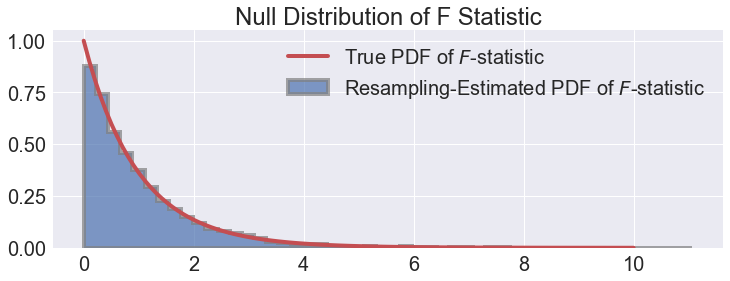

In [31]:
plt.figure(figsize=(12,4))
utils.plot_approximated_F(Fs)
utils.plot_true_F(dof["explained"], dof["residual"])

We can calculate an approximate $p$-value for the value of $F$ calculated above by subtracting one from the empirical cumulative density function of the `sorted_Fs` evaluated at the observed value.

#### Q7 Explain why subtracting one from the empirical CDF of the statistic under the null distribution evaluated at the observed value gives the $p$-value.

<font color="1874CD"> ** The CDF tells us the chance of getting a number less than the given value. Subtracting one gives the chance of getting a number greater than or equal to the given value. The $p$-value is precisely the chance, under the null, of observing a value greater than or equal to the one we observed in our experiment. **

The cell below checks that the answers given by this method and by `scipy` are in agreement.

In [23]:
def eCDF(F, sorted_Fs):
    try:
        index = np.where(sorted_Fs > F)[0][0] #returns a tuple of arrays, we want first element of first array
    except IndexError:
        index = len(sorted_Fs)
        
    return index/len(sorted_Fs)

approx_p = 1-eCDF(F, sorted_Fs)
       
_, scipy_p = run_ANOVA(pivot_data, measure)
       
(scipy_p - approx_p)**2

1.192080617915073e-07

As part of the process of generating our estimated $F$ distribution, we need to generate a bunch of data sets that are distributed according to the null hypothesis. We can use these, plus any method that calculates $p$-values, to simulate the distribution of $p$-values under the null hypothesis. The function `utils.simulate_null` will do this for us.

In [24]:
ps = utils.simulate_null(grouped_data, N=10000)

#### Q8 What sampling distribution do we expect the $p$-value to have under the null hypothesis? How might this distribution look different under the alternative hypothesis?

<font color="1874CD"> ** We expect the distribution of $p$ under the null hypothesis to be uniform. As the effect size gets larger, this distribution becomes more peaked close to 0. **

In the cell below, plot the simulated sampling distribution of the $p$-value. You'll want `sns.distplot`.

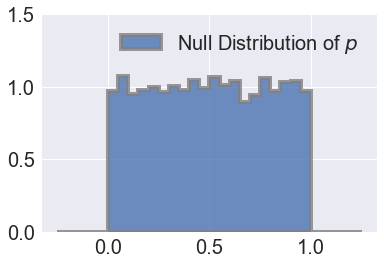

In [25]:
sns.distplot(ps, bins=np.arange(-0.25,1.3,0.05), kde=False,
             hist_kws={'histtype':'stepfilled',
                       'normed':True,
                       'linewidth':4,
                       'edgecolor':'gray',
                       'alpha':0.8}, label =r"Null Distribution of $p$");
plt.ylim([0, 1.5])
plt.legend();

### Beyond $p$ - Effect Size Reporting with $\eta^2$ and $\omega^2$

The $F$-statistic is used to determine the statistical significance of an ANOVA result.

Recall that previously, we've distinguished between practical/scientific and statistical significance. Statistical significance is centered around whether an effect exists at all.

#### Q9 How is this different from the practical or scientific significance of an ANOVA result?

<font color="1874CD"> ** Practical significance is determined by the purpose of the inquiry. Larger effects, relative to the ambient randomness, are generally more practically significant. They require smaller sample sizes to detect with high probability. Scientific significance is closer to practical significance than statistical significance.  **

The APA recommends that, in addition to reporting $F$ and $p$, scientists report the value $\eta^2$, which is equal to the ratio of the explained sum-of-squares to the explainable sum-of-squares. It's also known as the *variance explained*.

#### Q10 Why is this number closer to a notion of practical significance than $F$ is?

<font color="1874CD"> ** It tells you how much less uncertain, on average, that you become about the data values when you use your model. This more useful for practical purposes than whether the group labels and measurement values are likely independent. With a large enough $N$, you're likely to find a signficant but miniscule effect of any label. **

Calculate $\eta^2$ for a statistically significant test you ran above.

In [26]:
# answer
eta_sqrd = sum_of_squares["explained"]/sum_of_squares["explainable"]
eta_sqrd

0.13448401830499665

#### Q11 Does this seem like a practically significant fraction to you? Look back at the visualizations of the data you produced at the beginning of the lab. Are there any visual hints that would lead you to expect a value of $\eta^2$ close to what you calculated?

<font color="1874CD"> ** The heavy overlap of the groups in the case of `cda` and `fmt` indicates that the amount of variance explained is going to be low. **

Notice that $\eta^2$ uses the sums-of-squares, rather than mean squares.
This means that it doesn't take into account degrees of freedom
and is therefore a biased estimator of the quantity it is trying to capture:
it overestimates how much variance has been explained.
Intuitively, it only captures how well you explained your dataset,
not how well you might explain additional data from the same population.

An unbiased estimator for explained variance exists, known as $\omega^2$ (pronounced "omega-squared"). You can [read more about it here](http://daniellakens.blogspot.com/2015/06/why-you-should-use-omega-squared.html).

Use the following formula to compute $\omega^2$ for your test:

$$
    \omega^2 = \frac{F-1}{\frac{F+1+\text{df}_{residual}}{\text{df}_{explained}}}
$$

Template:
```python
om_sqrd = ?/(?/?)
```

In [27]:
# answer
om_sqrd = (F-1)/((F+dof["residual"]+1)/ dof["explained"] )
om_sqrd

0.1165177817766161

#### Q12 Does this more accurate estimate change your opinion of the the practical significance of the results of your test?

<font color="1874CD"> ** The switch from $\eta$ to $\omega$ shaves a few percentage points off of the purported variance explained. For small effect sizes, this can be a substantial fraction of $\eta^2$. **